In [2]:
%mkdir input
%mkdir outputs

In [3]:
!unzip /content/drive/MyDrive/Kaggle/asl-alphabet.zip -d /content/input

Streaming output truncated to the last 5000 lines.
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/input/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: /content/input/asl_

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import cv2
import random
import numpy as np
import argparse
from tqdm import tqdm

In [5]:

print(f"Preprocessing 3000 from each category...")
dir_paths = os.listdir('/content/input/asl_alphabet_train/asl_alphabet_train')
dir_paths.sort()
root_path = '/content/input/asl_alphabet_train/asl_alphabet_train'
# get --num-images images from each category
for idx, dir_path  in tqdm(enumerate(dir_paths), total=len(dir_paths)):
    all_images = os.listdir(f"{root_path}/{dir_path}")
    os.makedirs(f"/content/input/preprocessed_image/{dir_path}", exist_ok=True)
    for i in range(3000): # how many images to preprocess for each category
        # generate a random id between 0 and 2999
        rand_id = i
        image = cv2.imread(f"{root_path}/{dir_path}/{all_images[rand_id]}")
        image = cv2.resize(image, (224, 224))
        cv2.imwrite(f"/content/input/preprocessed_image/{dir_path}/{dir_path}{i}.jpg", image)
print('DONE')

  0%|          | 0/29 [00:00<?, ?it/s]

Preprocessing 3000 from each category...


100%|██████████| 29/29 [02:31<00:00,  5.24s/it]

DONE


In [ ]:
!pwd

/content


In [ ]:
ls | wc -l

3000


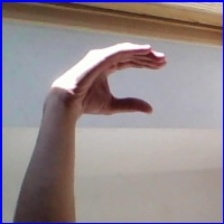

In [ ]:
from IPython.display import Image
Image('/content/input/preprocessed_image/C/C1.jpg')

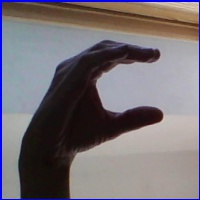

In [ ]:
Image('/content/input/asl_alphabet_train/asl_alphabet_train/C/C1.jpg')

In [6]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from imutils import paths

In [7]:
'''
USAGE:
python create_csv.py
'''

# get all the image paths
image_paths = list(paths.list_images('/content/input/preprocessed_image'))
# create a DataFrame 
data = pd.DataFrame()
labels = []
for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    label = image_path.split(os.path.sep)[-2]
    # save the relative path for mapping image to target
    data.loc[i, 'image_path'] = image_path
    labels.append(label)
labels = np.array(labels)
# one hot encode the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"The first one hot encoded labels: {labels[0]}")
print(f"Mapping the first one hot encoded label to its category: {lb.classes_[0]}")
print(f"Total instances: {len(labels)}")
for i in range(len(labels)):
    index = np.argmax(labels[i])
    data.loc[i, 'target'] = int(index)
# shuffle the dataset
data = data.sample(frac=1).reset_index(drop=True)
# save as CSV file
data.to_csv('/content/input/data.csv', index=False)
# pickle the binarized labels
print('Saving the binarized labels as pickled file')
joblib.dump(lb, '/content/outputs/lb.pkl')
print(data.head(5))

100%|██████████| 87000/87000 [03:17<00:00, 441.02it/s]


The first one hot encoded labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
Mapping the first one hot encoded label to its category: A
Total instances: 87000
Saving the binarized labels as pickled file
                                          image_path  target
0       /content/input/preprocessed_image/A/A340.jpg     0.0
1  /content/input/preprocessed_image/space/space1...    28.0
2       /content/input/preprocessed_image/H/H296.jpg     7.0
3       /content/input/preprocessed_image/E/E284.jpg     4.0
4       /content/input/preprocessed_image/E/E313.jpg     4.0


In [9]:
import torch.nn as nn
import torch.nn.functional as F
import joblib
# load the binarized labels
print('Loading label binarizer...')
lb = joblib.load('/content/outputs/lb.pkl')

Loading label binarizer...


In [27]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 3)
        
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, len(lb.classes_))
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.50) #dropout
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        bs, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) #dropout
        x = self.fc2(x)
        return x

In [28]:
'''
USAGE:
python train.py --epochs 10
'''
import pandas as pd
import joblib
import numpy as np
import torch
import random
import albumentations
import matplotlib.pyplot as plt
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import time
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [29]:
''' SEED Everything '''
def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)
''' SEED Everything '''
# set computation device
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")

Computation device: cuda:0


In [30]:
# read the data.csv file and get the image paths and labels
df = pd.read_csv('/content/input/data.csv')
X = df.image_path.values
y = df.target.values
(xtrain, xtest, ytrain, ytest) = (train_test_split(X, y, 
                                test_size=0.15, random_state=42))
print(f"Training on {len(xtrain)} images")
print(f"Validationg on {len(xtest)} images")

Training on 73950 images
Validationg on 13050 images


In [31]:
class ASLImageDataset(Dataset):
    def __init__(self, path, labels):
        self.X = path
        self.y = labels
        # apply augmentations
        self.aug = albumentations.Compose([
            albumentations.Resize(224, 224, always_apply=True),
        ])
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = cv2.imread(self.X[i])
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label = self.y[i]
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

In [32]:
train_data = ASLImageDataset(xtrain, ytrain)
test_data = ASLImageDataset(xtest, ytest)
 
# dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [33]:
# model = models.MobineNetV2(pretrained=True, requires_grad=False)
model = CustomCNN().to(device)
print(summary(model, (3, 224, 224), batch_size=32))
# total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 16, 220, 220]           1,216
         MaxPool2d-2         [32, 16, 110, 110]               0
            Conv2d-3         [32, 32, 106, 106]          12,832
         MaxPool2d-4           [32, 32, 53, 53]               0
            Conv2d-5           [32, 64, 51, 51]          18,496
         MaxPool2d-6           [32, 64, 25, 25]               0
            Linear-7                  [32, 128]           8,320
           Dropout-8                  [32, 128]               0
            Linear-9                   [32, 29]           3,741
Total params: 44,605
Trainable params: 44,605
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 18.38
Forward/backward pass size (MB): 396.53
Params size (MB): 0.17
Estimated Total Size (MB): 415.08
----------------------------------------

In [34]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss function
criterion = nn.CrossEntropyLoss()

In [35]:
def fit(model, dataloader):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(dataloader.dataset)
    train_accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

In [36]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(test_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == target).sum().item()
        
        val_loss = running_loss/len(dataloader.dataset)
        val_accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy

In [37]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
m=[]
x=int(input("Enter number of epochs: "))
for epoch in range(x):
    m.append(epoch)
    print(f"Epoch {epoch+1} of {x}")
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()

Enter number of epochs: 10


  0%|          | 0/2310 [00:00<?, ?it/s]

Epoch 1 of 10
Training


2311it [02:14, 17.17it/s]
  0%|          | 2/407 [00:00<00:21, 18.71it/s]

Train Loss: 0.0579, Train Acc: 41.31
Validating


408it [00:23, 17.30it/s]
  0%|          | 2/2310 [00:00<02:20, 16.46it/s]

Val Loss: 0.0230, Val Acc: 75.95
Epoch 2 of 10
Training


2311it [02:12, 17.44it/s]                          
  0%|          | 2/407 [00:00<00:21, 18.67it/s]

Train Loss: 0.0215, Train Acc: 75.74
Validating


408it [00:23, 17.61it/s]
  0%|          | 2/2310 [00:00<02:15, 17.06it/s]

Val Loss: 0.0124, Val Acc: 86.87
Epoch 3 of 10
Training


2311it [02:12, 17.49it/s]                          
  0%|          | 2/407 [00:00<00:21, 18.67it/s]

Train Loss: 0.0128, Train Acc: 85.64
Validating


408it [00:23, 17.69it/s]
  0%|          | 2/2310 [00:00<02:16, 16.97it/s]

Val Loss: 0.0044, Val Acc: 95.79
Epoch 4 of 10
Training


2311it [02:10, 17.72it/s]                          
  0%|          | 2/407 [00:00<00:20, 19.30it/s]

Train Loss: 0.0086, Train Acc: 90.49
Validating


408it [00:22, 17.98it/s]
  0%|          | 2/2310 [00:00<02:18, 16.66it/s]

Val Loss: 0.0025, Val Acc: 97.83
Epoch 5 of 10
Training


2311it [02:10, 17.73it/s]                          
  0%|          | 2/407 [00:00<00:22, 18.05it/s]

Train Loss: 0.0066, Train Acc: 92.74
Validating


408it [00:22, 17.85it/s]
  0%|          | 2/2310 [00:00<02:16, 16.85it/s]

Val Loss: 0.0028, Val Acc: 96.99
Epoch 6 of 10
Training


2311it [02:10, 17.75it/s]                          
  0%|          | 2/407 [00:00<00:22, 18.15it/s]

Train Loss: 0.0054, Train Acc: 94.16
Validating


408it [00:22, 17.81it/s]
  0%|          | 2/2310 [00:00<02:19, 16.54it/s]

Val Loss: 0.0013, Val Acc: 98.98
Epoch 7 of 10
Training


2311it [02:10, 17.77it/s]                          
  0%|          | 2/407 [00:00<00:21, 19.12it/s]

Train Loss: 0.0045, Train Acc: 95.18
Validating


408it [00:22, 17.95it/s]
  0%|          | 2/2310 [00:00<02:16, 16.94it/s]

Val Loss: 0.0008, Val Acc: 99.37
Epoch 8 of 10
Training


2311it [02:09, 17.81it/s]                          
  0%|          | 2/407 [00:00<00:21, 18.80it/s]

Train Loss: 0.0039, Train Acc: 95.83
Validating


408it [00:22, 17.84it/s]                         
  0%|          | 2/2310 [00:00<02:22, 16.21it/s]

Val Loss: 0.0011, Val Acc: 98.95
Epoch 9 of 10
Training


2311it [02:09, 17.80it/s]                          
  0%|          | 2/407 [00:00<00:21, 18.99it/s]

Train Loss: 0.0036, Train Acc: 96.27
Validating


408it [00:22, 17.86it/s]
  0%|          | 2/2310 [00:00<02:14, 17.12it/s]

Val Loss: 0.0007, Val Acc: 99.43
Epoch 10 of 10
Training


2311it [02:09, 17.85it/s]                          
  0%|          | 2/407 [00:00<00:21, 18.74it/s]

Train Loss: 0.0032, Train Acc: 96.64
Validating


408it [00:22, 17.81it/s]

Val Loss: 0.0006, Val Acc: 99.46


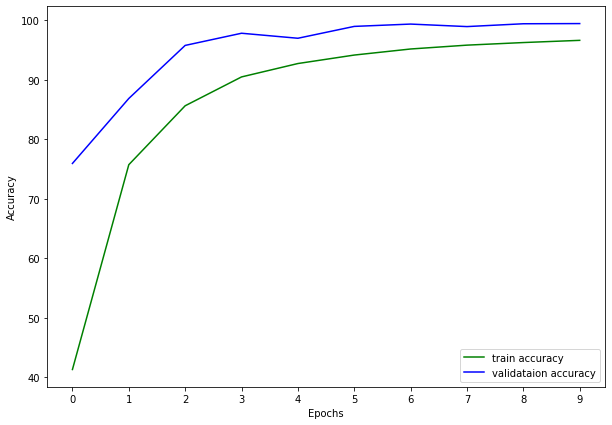

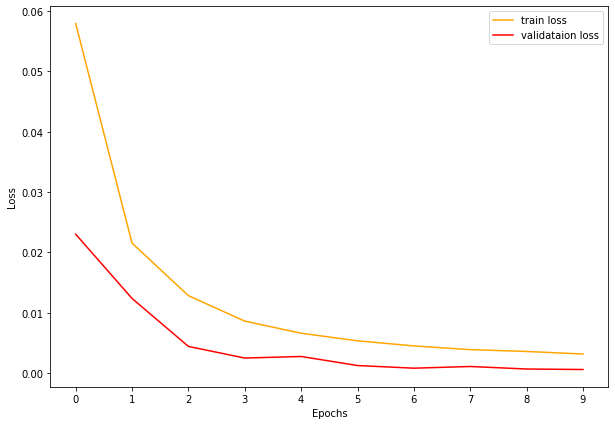

Saving model...


In [38]:
 # accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(m)
plt.legend()
plt.savefig('/content/outputs/accuracy.png')
plt.show()
 
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(m)
plt.legend()
plt.savefig('/content/outputs/loss.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), '/content/outputs/model.pth')

In [39]:
torch.save(model.state_dict(), '/content/drive/MyDrive/modelL3WD.pth')

In [ ]:
aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
])

image = cv2.imread(f"/content/input/asl_alphabet_test/asl_alphabet_test/I_test.jpg")
image_copy = image.copy()
 
image = aug(image=np.array(image))['image']
image = np.transpose(image, (2, 0, 1)).astype(np.float32)
image = torch.tensor(image, dtype=torch.float).cuda()
image = image.unsqueeze(0)
print(image.shape)
start = time.time()
outputs = model(image)
_, preds = torch.max(outputs.data, 1)
print('PREDS', preds)
print(f"Predicted output: {lb.classes_[preds]}")
end = time.time()
print(f"{(end-start):.3f} seconds")
 



torch.Size([1, 3, 224, 224])
PREDS tensor([8], device='cuda:0')
Predicted output: I
0.004 seconds


In [ ]:
for i in range(20):
  print(xtest[i],"---",ytest[i])

/content/input/preprocessed_image/C/C503.jpg --- 2.0
/content/input/preprocessed_image/V/V397.jpg --- 21.0
/content/input/preprocessed_image/S/S1173.jpg --- 18.0
/content/input/preprocessed_image/T/T379.jpg --- 19.0
/content/input/preprocessed_image/I/I230.jpg --- 8.0
/content/input/preprocessed_image/U/U661.jpg --- 20.0
/content/input/preprocessed_image/G/G736.jpg --- 6.0
/content/input/preprocessed_image/Z/Z871.jpg --- 25.0
/content/input/preprocessed_image/M/M218.jpg --- 12.0
/content/input/preprocessed_image/X/X215.jpg --- 23.0
/content/input/preprocessed_image/K/K643.jpg --- 10.0
/content/input/preprocessed_image/I/I243.jpg --- 8.0
/content/input/preprocessed_image/M/M604.jpg --- 12.0
/content/input/preprocessed_image/del/del526.jpg --- 26.0
/content/input/preprocessed_image/C/C573.jpg --- 2.0
/content/input/preprocessed_image/J/J29.jpg --- 9.0
/content/input/preprocessed_image/P/P1034.jpg --- 15.0
/content/input/preprocessed_image/Z/Z292.jpg --- 25.0
/content/input/preprocessed_i

In [ ]:
print(ytest)

[ 2. 21. 18. ... 21. 27.  1.]


In [40]:
aug = albumentations.Compose([
                albumentations.Resize(224, 224, always_apply=True),
])
qwe=[]
for i in xtest:
      image = cv2.imread(f"{i}")
      image_copy = image.copy()
      image = aug(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      image = torch.tensor(image, dtype=torch.float).cuda()
      image = image.unsqueeze(0)
      start = time.time()
      outputs = model(image)
      _, preds = torch.max(outputs.data, 1)
      qwe.append(preds.cpu().numpy())
qwe= [a.squeeze().tolist() for a in qwe]
print('PREDS', len(qwe))


PREDS 13050


In [41]:
from sklearn.metrics import confusion_matrix, classification_report
labelu=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
print(classification_report(ytest, qwe,target_names=labelu))

              precision    recall  f1-score   support

           A       0.99      1.00      0.99       442
           B       1.00      1.00      1.00       442
           C       0.99      1.00      1.00       477
           D       1.00      1.00      1.00       459
           E       1.00      1.00      1.00       453
           F       1.00      1.00      1.00       445
           G       1.00      1.00      1.00       461
           H       1.00      1.00      1.00       429
           I       1.00      1.00      1.00       426
           J       1.00      1.00      1.00       442
           K       0.99      1.00      0.99       455
           L       0.98      1.00      0.99       422
           M       0.99      1.00      0.99       465
           N       1.00      0.98      0.99       432
           O       1.00      1.00      1.00       456
           P       0.99      1.00      0.99       465
           Q       1.00      0.99      0.99       459
           R       1.00    

In [42]:
from sklearn.metrics import confusion_matrix


In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

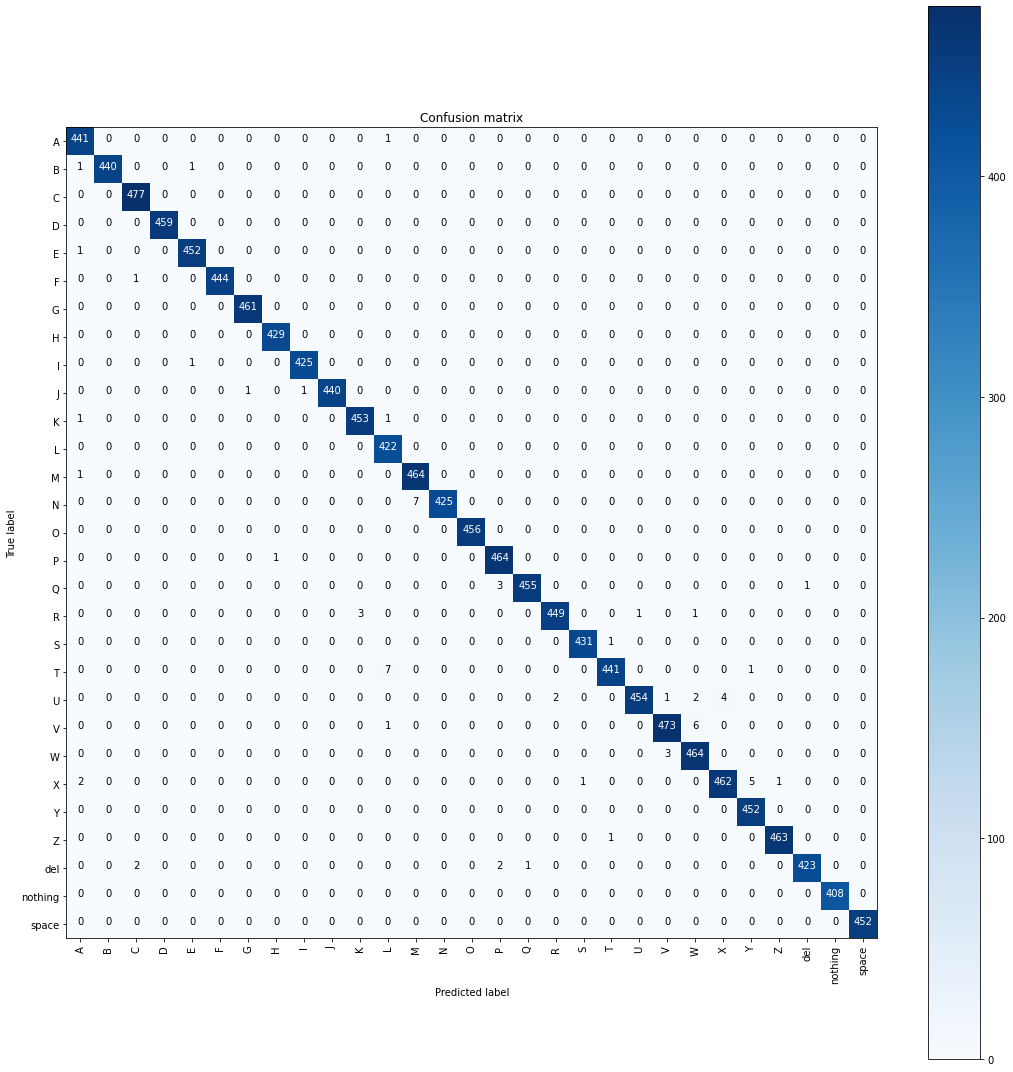

In [44]:
import itertools 
confusion_mtx = confusion_matrix(ytest, qwe)
plot_confusion_matrix(confusion_mtx, classes = labelu)
plt.show()

In [45]:
from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(ytest, qwe)
print(kappa)

0.9943647912130664
